In [1]:
import pandas as pd
import numpy as np
import string
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
path = '/Users/mjg/Desktop/5. Coding/NLP excercisses/5. Sentiment Analysis/balanced_sentiment 5.0k.csv'
df = pd.read_csv(path)

df.head(5)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.isna().sum()

sentiment    0
text         0
dtype: int64

In [4]:
df['sentiment'].value_counts()

0    5000
1    5000
Name: sentiment, dtype: int64

# Lowercase

In [5]:
def lowercase(df):
    df['text'] = df['text'].str.lower()
    return df

# Assuming df is already defined and loaded with data
df = lowercase(df)
print(df.head(5))


   sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - awww, t...
1          0  is upset that he can't update his facebook by ...
2          0  @kenichan i dived many times for the ball. man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....


# Punctuation

In [6]:
def punctuation(df):
    # Define a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', string.punctuation)

    df['text'] = df['text'].apply(lambda x: x.translate(translator))

    return df

df = punctuation(df)
print(df.head(5))

   sentiment                                               text
0          0  switchfoot httptwitpiccom2y1zl  awww thats a b...
1          0  is upset that he cant update his facebook by t...
2          0  kenichan i dived many times for the ball manag...
3          0    my whole body feels itchy and like its on fire 
4          0  nationwideclass no its not behaving at all im ...


# Remove stopwords

In [7]:
# def ensure_nltk_data():
#     try:
#         stop_words = set(stopwords.words('english'))
#     except LookupError:
#         nltk.download('stopwords')
#         stop_words = set(stopwords.words('english'))

#     try:
#         nltk.data.find('tokenizers/punkt')
#     except LookupError:
#         nltk.download('punkt')

# ensure_nltk_data()
# # load the set of stopwords
# stop_words = set(stopwords.words('english'))

# #check if we get stopwords
# a = 0
# for w in stop_words:
#     print(w)
#     a += 1
#     if a == 5:
#         break

In [8]:
# def remove_stopwords(cell):
#     words = cell.split()
#     filtered_words = [w for w in words if w not in stop_words] 
#     return ' '.join(filtered_words)

# df['text'] = df['text'].apply(remove_stopwords)
# print(df.head(5))

In [9]:
df.isna().sum()

sentiment    0
text         0
dtype: int64

# Tokenize

In [10]:
def tokenize(cell):
    return word_tokenize(cell)

df['text'] = df['text'].apply(tokenize)
print(df.head(5))

   sentiment                                               text
0          0  [switchfoot, httptwitpiccom2y1zl, awww, thats,...
1          0  [is, upset, that, he, cant, update, his, faceb...
2          0  [kenichan, i, dived, many, times, for, the, ba...
3          0  [my, whole, body, feels, itchy, and, like, its...
4          0  [nationwideclass, no, its, not, behaving, at, ...


# Embeddings

In [11]:
file_path_embeddings = '/Users/mjg/Desktop/5. Coding/NLP excercisses/5. Sentiment Analysis/glove/glove.6B.200d.txt'

def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def get_embedding(word, embeddings):
    return embeddings.get(word, None)

embeddings = load_glove_embeddings(file_path_embeddings)


def embed(cell):
    vectors = []
    for t in cell:  # Assuming cell is already a list of tokens
        vector = get_embedding(t, embeddings)
        if vector is not None:
            vectors.append(vector)
    return vectors

df['text'] = df['text'].apply(embed)
df.head(5)

,sentiment,text
0,0,"[[-0.13705, 0.41023, -0.20412, -0.66066, 0.408..."
1,0,"[[0.32928, 0.25526, 0.26753, -0.084809, 0.2976..."
2,0,"[[0.26805, 0.36032, -0.332, -0.54642, -0.50451..."
3,0,"[[0.3038, 0.18126, 0.46583, -0.6644, -0.4407, ..."
4,0,"[[0.65979, 0.52476, 0.022174, -0.43734, -0.144..."


# Remove empty rows
Because we performed transformations that my result in empty rows (if no words have corresponding embedding) now is the time to clean the df from those rows

In [12]:
def is_empty_or_nested_empty(cell):
    if isinstance(cell, list):
        if not cell:  # Check if the list itself is empty
            return True
        for item in cell:
            if isinstance(item, list) and not item:  # Check if there are nested empty lists
                return True
    return False

# Apply the function to each cell in the 'text' column
df['is_empty'] = df['text'].apply(is_empty_or_nested_empty)

# Filter the DataFrame to find rows with empty or nested empty lists
empty_rows = df[df['is_empty']]

# Extract the indexes of rows with empty or nested empty lists
empty_rows_indexes = empty_rows.index.tolist()

# Print the indexes of rows with empty or nested empty lists
print("Indexes of rows with empty or nested empty lists:")
print(empty_rows_indexes)

# Optionally, print the count
empty_count = len(empty_rows_indexes)
print(f"\nNumber of rows with empty or nested empty lists: {empty_count}")

Indexes of rows with empty or nested empty lists:
[135, 208, 249, 282, 398, 430, 1011, 1014, 1231, 1421, 1486, 1641, 2225, 2898, 4318, 4377, 4508, 5220, 5321, 5463, 5793, 5879, 6184, 6349, 6420, 6481, 6559, 6800, 7054, 7245, 7341, 7375, 7491, 7583, 7597, 7650, 7715, 7774, 8529, 8581, 8805, 9018, 9314, 9536, 9647, 9652, 9711, 9974]

Number of rows with empty or nested empty lists: 48


In [13]:
df_empty_rows = df.loc[empty_rows_indexes]

# Print the DataFrame with empty or nested empty lists
print("\nDataFrame with rows that contain empty or nested empty lists:")
print(df_empty_rows)


DataFrame with rows that contain empty or nested empty lists:
      sentiment text  is_empty
135           0   []      True
208           0   []      True
249           0   []      True
282           0   []      True
398           0   []      True
430           0   []      True
1011          0   []      True
1014          0   []      True
1231          0   []      True
1421          0   []      True
1486          0   []      True
1641          0   []      True
2225          0   []      True
2898          0   []      True
4318          0   []      True
4377          0   []      True
4508          0   []      True
5220          1   []      True
5321          1   []      True
5463          1   []      True
5793          1   []      True
5879          1   []      True
6184          1   []      True
6349          1   []      True
6420          1   []      True
6481          1   []      True
6559          1   []      True
6800          1   []      True
7054          1   []      True
7245   

In [14]:
df = df.drop(empty_rows_indexes)

# Drop the helper column 'is_empty'
df = df.drop(columns=['is_empty'])

# Print the cleaned DataFrame
print("Cleaned DataFrame with rows containing empty or nested empty lists removed:")
print(df.head(5))

Cleaned DataFrame with rows containing empty or nested empty lists removed:
   sentiment                                               text
0          0  [[-0.13705, 0.41023, -0.20412, -0.66066, 0.408...
1          0  [[0.32928, 0.25526, 0.26753, -0.084809, 0.2976...
2          0  [[0.26805, 0.36032, -0.332, -0.54642, -0.50451...
3          0  [[0.3038, 0.18126, 0.46583, -0.6644, -0.4407, ...
4          0  [[0.65979, 0.52476, 0.022174, -0.43734, -0.144...


In [15]:
len(df)

9952

# Check max length

In [16]:
df['length'] = df['text'].apply(len)

# Find the length of the longest sequence
max_length = df['length'].max()

# Print the length of the longest sequence
print(f"The length of the longest sequence in the 'text' column is: {max_length}")


The length of the longest sequence in the 'text' column is: 34


In [17]:
df = df.drop(columns=['length'])

# Padding

In [18]:
# get dynamically embedding dim
first_word = next(iter(embeddings))
embedding_dim = len(embeddings[first_word])


In [19]:
# Function to pad sequences
def pad_sequence_custom(sequence, maxlen, embedding_dim):
    sequence = [torch.tensor(vec, dtype=torch.float32) for vec in sequence if len(vec) > 0]
    if len(sequence) == 0:
        sequence = [torch.zeros(embedding_dim, dtype=torch.float32)]
    padded_sequence = pad_sequence(sequence, batch_first=True, padding_value=0)
    if padded_sequence.size(0) < maxlen:
        padding = torch.zeros(maxlen - padded_sequence.size(0), embedding_dim, dtype=torch.float32)
        padded_sequence = torch.cat([padded_sequence, padding], dim=0)
    elif padded_sequence.size(0) > maxlen:
        padded_sequence = padded_sequence[:maxlen]
    return padded_sequence.tolist()

# Apply padding to each sequence in the 'text' column
df['text'] = df['text'].apply(lambda x: pad_sequence_custom(x, max_length, embedding_dim))

# Print the DataFrame with padded sequences
print("DataFrame with padded sequences:")
print(df.head(5))

DataFrame with padded sequences:
   sentiment                                               text
0          0  [[-0.13705000281333923, 0.41023001074790955, -...
1          0  [[0.32927998900413513, 0.25525999069213867, 0....
2          0  [[0.2680499851703644, 0.36032000184059143, -0....
3          0  [[0.30379998683929443, 0.18126000463962555, 0....
4          0  [[0.6597899794578552, 0.5247600078582764, 0.02...


# Check the shapes

In [20]:
def check_uniform_length_and_dimension(df, column_name, expected_length, expected_dimension):
    lengths = df[column_name].apply(len)
    dimensions = df[column_name].apply(lambda seq: all(len(embedding) == expected_dimension for embedding in seq))
    
    uniform_length = all(length == expected_length for length in lengths)
    uniform_dimension = all(dimensions)
    
    return uniform_length, uniform_dimension, lengths, dimensions

uniform_length, uniform_dimension, lengths, dimensions = check_uniform_length_and_dimension(df, 'text', max_length, embedding_dim)

# Print results
if uniform_length and uniform_dimension:
    print(f"All sequences have the same length of {max_length} and each embedding has the dimension of {embedding_dim}.")
else:
    if not uniform_length:
        print("Not all sequences have the same length.")
        print(lengths)
    if not uniform_dimension:
        print("Not all embeddings have the expected dimension.")
        print(dimensions)

All sequences have the same length of 34 and each embedding has the dimension of 200.


# Dataset & Data loaders

In [21]:
class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.df['text'].iloc[idx], dtype=torch.float32)
        target_data = torch.tensor(self.df['sentiment'].iloc[idx], dtype=torch.float32).unsqueeze(0)  # Ensure targets have shape [1]
        return input_data, target_data

In [22]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.head(5)

,sentiment,text
0,0,"[[-0.482340008020401, -0.2888000011444092, 0.0..."
1,1,"[[0.148049995303154, 0.10875000059604645, -0.0..."
2,1,"[[0.22223000228405, -0.6527799963951111, -0.22..."
3,0,"[[0.21193000674247742, 0.3873099982738495, -0...."
4,0,"[[0.2680499851703644, 0.36032000184059143, -0...."


In [23]:
dataset = MyDataset(df_shuffled)

# Calculate lengths for train, validation, and test splits
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
dataset_train, dataset_val, dataset_test = random_split(dataset, [train_size, val_size, test_size])

# Print the lengths of the datasets
print(f"Training set size: {len(dataset_train)}")
print(f"Validation set size: {len(dataset_val)}")
print(f"Test set size: {len(dataset_test)}")

Training set size: 7961
Validation set size: 995
Test set size: 996


In [24]:
# Create DataLoaders for each dataset
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False)

# Example of iterating through the DataLoader
for batch in train_loader:
    inputs, targets = batch
    print("Batch inputs shape:", inputs.shape)
    print("Batch targets shape:", targets.shape)
    break


Batch inputs shape: torch.Size([16, 34, 200])
Batch targets shape: torch.Size([16, 1])


# LSTM

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.norm = nn.BatchNorm1d(input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, input_dim = x.size()
        #x = x.view(batch_size * seq_len, input_dim)     # Reshape x for batch normalization
        
        #x = self.norm(x)                                # Normalize batch
        #x = x.view(batch_size, seq_len, input_dim)      # Reshape x back to (batch_size, seq_len, input_dim)
        h0, c0 = self.hidden_init(batch_size)           # Initialize hidden state and cell state
        out, _ = self.lstm(x, (h0, c0))                 # LSTM forward pass
        out = self.fc(out[:, -1, :])                    # Fully connected layer (take the last time step output)
        return out

    def hidden_init(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        return h0, c0

# Train function

In [26]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()

    # Define the loss function and the optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits for binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            # Move inputs and targets to the appropriate device (CPU or GPU)
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device).float()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)  # Ensure outputs is of shape (batch_size, 1)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss
            running_loss += loss.item()
        
        # Print average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Validate the model
        validate_model(model, val_loader)

def validate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():  # Turn off gradients for validation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device).float()
            outputs = model(inputs)  # Ensure outputs is of shape (batch_size, 1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
    model.train()  # Set the model back to training mode

# Initialise

In [31]:
batch_size = 16
input_dim = embedding_dim   # The number of input features per time step. This corresponds to the dimensionality of the input vectors
hidden_dim = 512       # The number of features in the hidden state of the LSTM. It defines the internal state representation size of the LSTM. Higher values allow the LSTM to capture more complex patterns but also increase the computational cost.
output_dim = 1     
num_layers = 2
dropout = 0.3
num_epochs = 10
learning_rate = 0.00007

In [32]:
# Device

In [33]:
model = LSTM(input_dim, hidden_dim, output_dim, num_layers, dropout)

# Assume dataset_train and dataset_val are already created
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Train the model
train_model(model, train_loader, val_loader, num_epochs, learning_rate)

Epoch [1/10], Loss: 0.6921
Validation Loss: 0.6918
Epoch [2/10], Loss: 0.6371
Validation Loss: 0.6180
Epoch [3/10], Loss: 0.5790
Validation Loss: 0.5784
Epoch [4/10], Loss: 0.5585
Validation Loss: 0.5589


# test model

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Turn off gradients for evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device).float()
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get binary predictions
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets.numpy(), all_preds.numpy())
    print("Confusion Matrix:")
    print(cm)
    
    # Compute classification report
    report = classification_report(all_targets.numpy(), all_preds.numpy(), target_names=['Class 0', 'Class 1'])
    print("\nClassification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



Confusion Matrix:
[[387 122]
 [157 330]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.76      0.74       509
     Class 1       0.73      0.68      0.70       487

    accuracy                           0.72       996
   macro avg       0.72      0.72      0.72       996
weighted avg       0.72      0.72      0.72       996



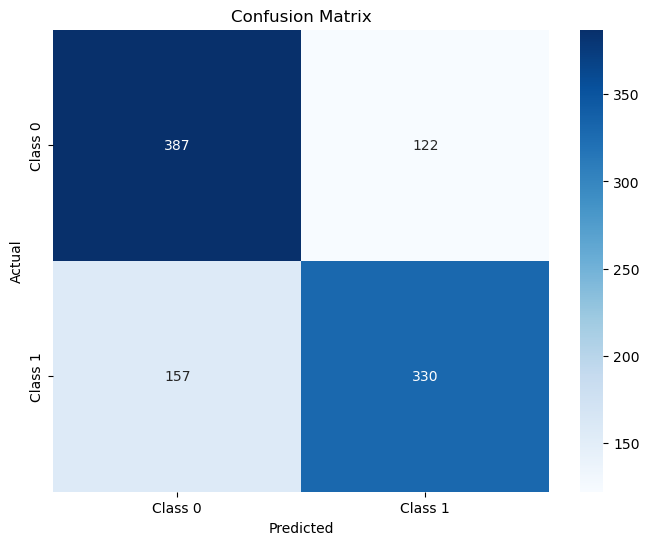

In [ ]:
# Example usage
test_model(model, test_loader)